The dataset is referenced as **Flickr Logos 27 Dataset**, which could be accessed using this url http://image.ntua.gr/iva/datasets/flickr_logos/  
     
The training data consists of **4536 images of logos belonging to 27 companies (168 for each)** along with the annotation of the location of the logo in the image. The test data (which will be referred to as **Query data** moving forward)however, only have labels and NOT the annotations of the location of the logos. 

In [1]:
# Importing libraries
import os
import re
import cv2
import joblib
import numpy as np
import pandas as pd
from PIL import ImageOps
from sklearn import svm
import joblib
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
### Reading annotations and labels for training data

train_img_label_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_training_set_annotation.txt")

train_images = pd.read_csv(train_img_label_file,
                           sep=' ', 
                           usecols = [i for i in range(7)],
                           header=None,  
                           names=["file_name",'label','subset','x1','y1','x2','y2'])

In [3]:
train_images.head()

,file_name,label,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


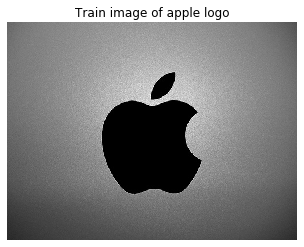

In [4]:
idx = 465
pth = 'data/'+train_images.loc[idx,'file_name']
image = Image.open(pth)
plt.imshow(image)
plt.axis("off")
plt.title("Train image of apple logo")
plt.show()

****

The target variable is **'label'**, which is the brand corresponding the particular image containing the logo. And the predictors are the 3 channel RGB values in a image.

Yes, the data is being pre-processed before being used in the training of a classifier. Following transformation would be done on the data :   
    
1. Cropping the image using the annotations (in case of trainig data)
2. Converting from RGB channel to grayscale (for dimensionality reduction)
3. Equalizing image histogram.
4. Randomly rotation the image 
5. Calculating Histogram of Oriented Gradient (HOG) of the image
6. Coversion of the image to a numpy array.
7. Normalizing and scaling the numpy array values using *Standard Scaler*

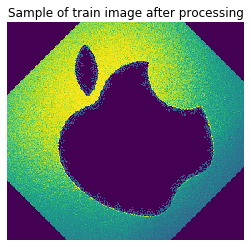

In [5]:
# Testing image processing methods 
# Cropping using annotations and changing it to greyscale along with equalizing
idx = 465
pth = 'data/'+train_images.loc[idx,'file_name']
image = Image.open(pth)
image = image.crop([train_images.loc[idx,'x1'],train_images.loc[idx,'y1'],train_images.loc[idx,'x2'],train_images.loc[idx,'y2']])
image = ImageOps.grayscale(image)
image = ImageOps.equalize(image)
image = image.rotate(45)

plt.imshow(image)
plt.axis('off')
plt.title("Sample of train image after processing")
plt.show()

***

## Data Pre-processing

In [6]:
#Cropping using annotations,changing it to greyscale along with equalizing and resizing

def image_processor(label_df,crop=True):
    '''
    function to read and pre process training images with labels
    Returns a numpy array of images
    '''
    angle = [0,45,90,135]
    train_img_arr = []
    num_images = len(label_df)
    for i in range(num_images):
        pth = 'data/'+label_df.loc[i,'file_name']
        image = Image.open(pth)
        if crop == True :
            x1 = train_images.loc[i,'x1']
            y1 = train_images.loc[i,'y1']
            x2 = train_images.loc[i,'x2']
            y2 = train_images.loc[i,'y2']
            image = image.crop([x1,y1,x2,y2])
        image = ImageOps.grayscale(image)
        image = ImageOps.equalize(image)
        
        train_img_arr.append(np.asarray(image.resize([64,64]),dtype="int32")) 
    return np.array(train_img_arr)

In [7]:
train_data = image_processor(train_images)
y = train_images['label']
train_data.shape

(4536, 64, 64)

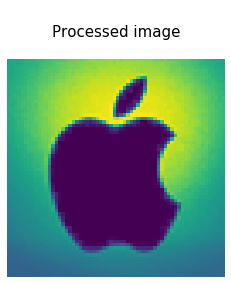

In [8]:
# resized processed image
plt.imshow(train_data[465])
plt.axis('off')   
plt.title("\nProcessed image\n", size=15)
plt.show()

## Applying HOG (Histogram of Oriented gradient)

In [9]:
from skimage import color
from skimage.feature import hog

In [20]:
def HOG(img_arr,ppc=16,cpb=4):
    hog_images = []
    hog_features = []
    for image in img_arr:
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),
                           cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
        
    print("\nHOG Completed on {} images, with {} features\n"
          .format(np.shape(hog_features)[0],np.shape(hog_features)[1]))   
    
    return hog_images, hog_features

In [21]:
hog_images, hog_features = HOG(train_data)


HOG Completed on 4536 images, with 128 features



In [22]:
np.shape(hog_features[0])

(128,)

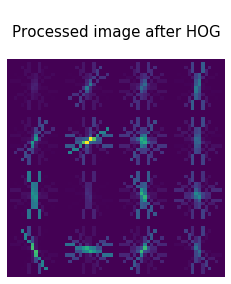

In [23]:
# analyzing images after HOG 

plt.imshow(hog_images[460])
plt.axis('off')   
plt.title("\nProcessed image after HOG\n", size=15)
plt.show()

In [24]:
feature_vec_train = np.array(hog_features)
print(np.shape(feature_vec_train))

sc = StandardScaler()
feature_vec_train = sc.fit_transform(feature_vec_train)

(4536, 128)


## Training the classifier

In [25]:
#Training the classifier on the actual training dataset with 4536 annotated logo images
clf = svm.SVC()
clf.fit(feature_vec_train, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
joblib.dump(clf, 'logo_classifier.joblib')

['logo_classifier.joblib']

In [28]:
joblib.dump(sc, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [23]:
clf = joblib.load('logo_classifier.joblib')

In [ ]:
# Pre-process the test images before classifcication
# call the image_processor
# call HOG
# predict
# return label 

****
$\hspace{16cm}END$
****